# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


(7591, 2)

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Text(0, 0.5, 'Количество наблюдений')

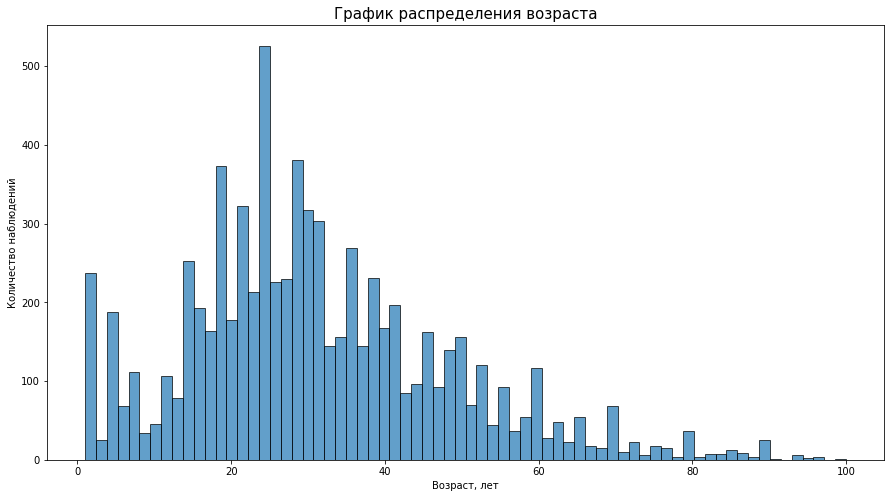

In [8]:
display(labels.head(3))
display(labels.shape)
display(labels.describe())
plt.figure(figsize=[15, 8])
plt.title('График распределения возраста', fontsize=15)
plt.hist(labels.real_age, bins=70, alpha = 0.7, ec='black')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество наблюдений')

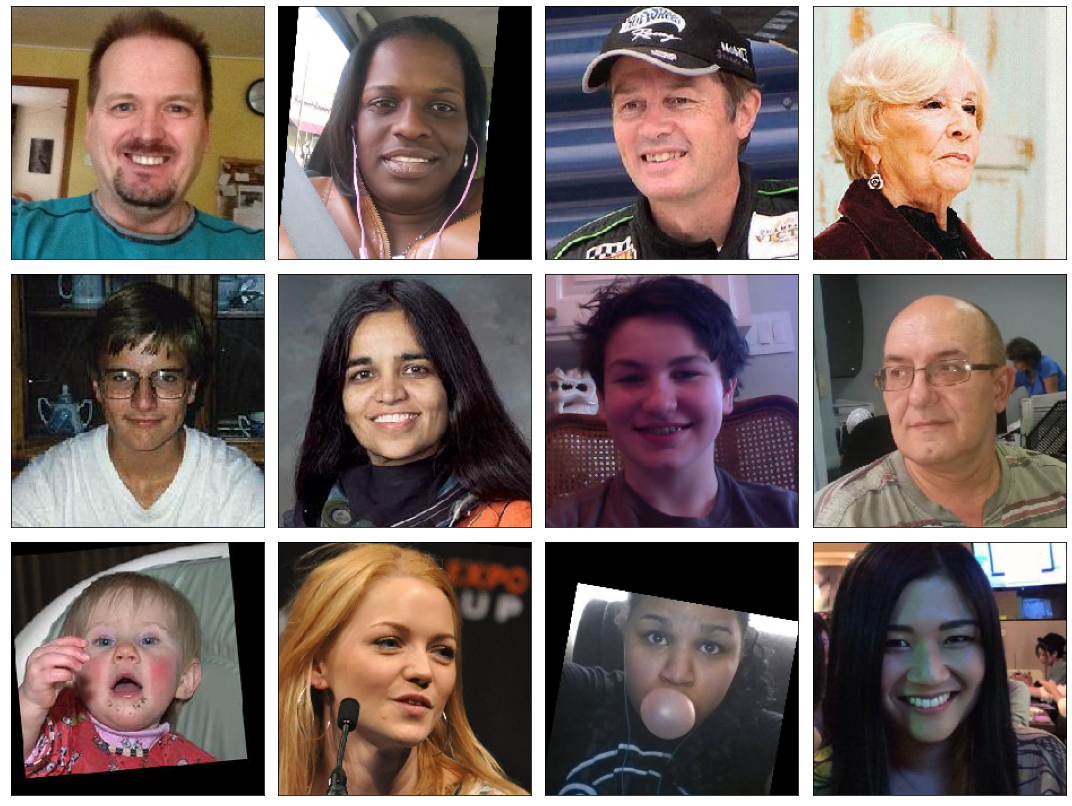

In [4]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод
1.  Всего в датасете 7591 фотография, что не очень много для оценки возраста.

2. Большая часть возарста людей находится в диапазоне от 20 до 41 года, при этом средний возраст около 30 лет.

3. На фотографиях есть объекты, которые будут мешать обучению - микрофон, жвательная резинка и тд. Ориентация фото практически одинаковая.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-03-22 10:05:21.539855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-22 10:05:21.854349: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 71s - loss: 197.6883 - mae: 10.2534 - val_loss: 802.4264 - val_mae: 23.3067
Epoch 2/10
356/356 - 44s - loss: 86.1961 - mae: 7.0306 - val_loss: 140.9227 - val_mae: 8.8190
Epoch 3/10
356/356 - 44s - loss: 58.3550 - mae: 5.8168 - val_loss: 93.3709 - val_mae: 7.4166
Epoch 4/10
356/356 - 44s - loss: 42.7603 - mae: 4.9746 - val_loss: 72.4950 - val_mae: 6.3687
Epoch 5/10
356/356 - 55s - loss: 35.3923 - mae: 4.5769 - val_loss: 69.3040 - val_mae: 6.2268
Epoch 6/10
356/356 - 57s - loss: 25.5707 - mae: 3.8909 - val_loss: 75.6852 - val_mae: 6.6401
Epoch 7/10
356/356 - 56s - loss: 21.6260 - mae: 3.5552 - val_loss: 68.9402 - val_mae: 6.1358
Epoch 8/10
356/356 - 57s - loss: 17.3949 - mae: 3.2002 - val_loss: 74.9137 - val_mae: 6.5441
Epoch 9/10
356/356 - 57s - loss: 15.4896 - mae: 2.9881 - val_loss: 65.2399 - val_mae: 6.0914
Epoch 10/10
356/356 - 56s - loss: 13.9636 - mae: 2.8439 - val_loss: 66.2950 - val_mae: 6.0746
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 66.2950 - mae: 6.0746
Test MAE: 6.0746




```

## Анализ обученной модели

Модель успешно обучена, результат метрики MAE 6.07, что удовлетворяет условию <7. Для обучения модели была использована аугментация, архитектура resnet50 и оптимайзер Аdam с частотой 0.0001. Обучение модели не заняло слишком много времени, вероятно, это связано с небольшим количеством изображений в выборке. Значение ошибки составило около 6 лет, что в целом не критично, кроме ситуации, когда идет речь о табачных либо алкогольных товарах. Возможно, стоит отсекать возраст ниже 21 года по предъявлению удостоверяющих документов, без которых не предлагать товары с ограничениями по возрасту.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы


<b> дополнительные материалы </b>
    
   - "Дип Лернинг на пальцах" (https://www.youtube.com/playlist?list=PL5FkQ0AF9O_o2Eb5Qn8pwCDg7TniyV1Wb).
   - Отличный бесплатный курс от Школы глубокого обучения МФТИ (https://stepik.org/org/dlschool), старт курса каждые пол года. Два семестра, один по основам и компьютерному зрению, второй по обработке естественного языка.
   - "Нейронные сети и компьютерное зрение" от Samsung Research Russia (https://stepik.org/course/50352/syllabus). Есть также продолжение по NLP.  

</div>